In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import cv2


import torch
import torchaudio
from torchvision.transforms import Resize
from torchvision.utils import save_image
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

In [2]:
# config
N_FFT = 2048
HOP_LEN = 512

In [3]:
# keeping everything in torch for faster processing
def create_spectrogram(filename):
    """
    usage: converts .ogg to mel spectogram
    """
    audio, sr = torchaudio.load(filename)
    specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
                                                    n_fft=N_FFT, 
                                                    win_length=N_FFT, 
                                                    hop_length=HOP_LEN*4,
                                                    center=True,
                                                    pad_mode="reflect",
                                                    power=2.0,
                                                    norm='slaney',
                                                    onesided=True,
                                                    n_mels=128,
                                                    mel_scale="htk"
                                                   )(audio)[0]
    specgram = torchaudio.transforms.AmplitudeToDB()(specgram)
    specgram = specgram - specgram.min()
    specgram = specgram/specgram.max()*255
    specgram = specgram.reshape((1,specgram.shape[0],specgram.shape[1])) 

    shaper = Resize(size=(256,256))
    specgram = shaper(specgram)

    return specgram

In [4]:
# loading train and test df
DIR = "../input/kaggle-pog-series-s01e02/"
train = pd.read_csv("../input/kaggle-pog-series-s01e02/train.csv")
test = pd.read_csv("../input/kaggle-pog-series-s01e02/test.csv")
display(train)
display(test)

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock
...,...,...,...,...,...
19917,9337,009337.ogg,train/009337.ogg,0,Electronic
19918,8340,008340.ogg,train/008340.ogg,4,Hip-Hop
19919,16248,016248.ogg,train/016248.ogg,4,Hip-Hop
19920,11875,011875.ogg,train/011875.ogg,2,Punk


,song_id,filename,filepath
0,7072,007072.ogg,test/007072.ogg
1,10207,010207.ogg,test/010207.ogg
2,20008,020008.ogg,test/020008.ogg
3,10924,010924.ogg,test/010924.ogg
4,21896,021896.ogg,test/021896.ogg
...,...,...,...
5073,6427,006427.ogg,test/006427.ogg
5074,16903,016903.ogg,test/016903.ogg
5075,1731,001731.ogg,test/001731.ogg
5076,12871,012871.ogg,test/012871.ogg


# create dest folders

In [5]:
# destination folders
!mkdir -p melspecs/train
!mkdir -p melspecs/test

TRAIN_DIR = "melspecs/train"
TEST_DIR = "melspecs/test"

# engine loop

In [6]:
def save_raw(df,DEST_DIR):
    """
    usage: saves raw mel spectograms to .png files
    """
    # df.itertuples() is faster: https://twitter.com/radekosmulski/status/1504835035693654018?s=20&t=2kmlBULUIuGT8YjEWqPokA
    print("loading and saving🤖")
    bar = tqdm(enumerate(df.itertuples()), total=len(df))
    curropted_files = []
    for i, x in bar:
        file_path = os.path.join(DIR,x.filepath)
        try:
            melspec = create_spectrogram(file_path).permute(1,2,0).numpy()
            file_name = x.filename.split(".")[0] + ".png"
            dest_path = os.path.join(DEST_DIR,file_name)
            cv2.imwrite(dest_path,melspec)
        except:
            curropted_files.append(file_path)
    print("Done ... :)")
    
    return curropted_files

In [7]:
%%time
train_corropt = save_raw(train,TRAIN_DIR)
print("corrupted files",train_corropt)

loading and saving🤖


100%|██████████| 19922/19922 [47:55<00:00,  6.93it/s]

Done ... :)
corrupted files ['../input/kaggle-pog-series-s01e02/train/003137.ogg', '../input/kaggle-pog-series-s01e02/train/011088.ogg', '../input/kaggle-pog-series-s01e02/train/016312.ogg', '../input/kaggle-pog-series-s01e02/train/024899.ogg', '../input/kaggle-pog-series-s01e02/train/004040.ogg', '../input/kaggle-pog-series-s01e02/train/009963.ogg', '../input/kaggle-pog-series-s01e02/train/015980.ogg', '../input/kaggle-pog-series-s01e02/train/022698.ogg', '../input/kaggle-pog-series-s01e02/train/023078.ogg', '../input/kaggle-pog-series-s01e02/train/017940.ogg', '../input/kaggle-pog-series-s01e02/train/022295.ogg', '../input/kaggle-pog-series-s01e02/train/003071.ogg', '../input/kaggle-pog-series-s01e02/train/013954.ogg']
CPU times: user 53min 51s, sys: 1min 20s, total: 55min 11s
Wall time: 47min 55s


In [8]:
%%time
test_corropt = save_raw(test,TEST_DIR)
print("corrupted files",test_corropt)

loading and saving🤖


100%|██████████| 5078/5078 [12:23<00:00,  6.83it/s]

Done ... :)
corrupted files ['../input/kaggle-pog-series-s01e02/test/022612.ogg', '../input/kaggle-pog-series-s01e02/test/024013.ogg']
CPU times: user 13min 49s, sys: 26 s, total: 14min 15s
Wall time: 12min 23s


In [9]:
# !ls -A $TRAIN_DIR

# load save and reload demo

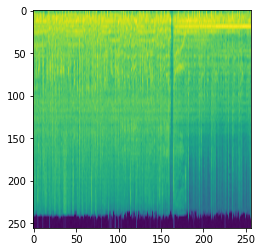

In [10]:
fullpath = os.path.join(DIR,train["filepath"].iloc[1])
melspect = create_spectrogram(fullpath)
melspecnp = create_spectrogram(fullpath).permute(1,2,0).numpy()
plt.imshow(melspecnp)

In [11]:
melspecnp.dtype

dtype('float32')

float32


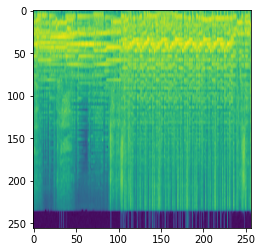

In [12]:
demo_file = os.path.join(TRAIN_DIR, "008458.png")
demo_img = plt.imread(demo_file)
print(demo_img.dtype)
plt.imshow(demo_img)